In [1]:
import mujoco
import mujoco_viewer
import random
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial.transform import Rotation


In [2]:

height = 480
width = height

model = mujoco.MjModel.from_xml_path("/home/luangb/Documents/TCC/Kuka_RL_Control/sim_env/environment.xml")
data = mujoco.MjData(model)
viewer = mujoco_viewer.MujocoViewer(model, data,"offscreen",width=width,height=height)
mujoco.mj_forward(model, data)
img,depth = viewer.read_pixels(camid=0,depth=True)

# Get the distances to the near and far clipping planes.
extent = model.stat.extent
near = model.vis.map.znear  * extent
far = model.vis.map.zfar * extent
# Convert from [0 1] to depth in meters, see links below:
# http://stackoverflow.com/a/6657284/1461210
# https://www.khronos.org/opengl/wiki/Depth_Buffer_Precision
depth_meters = near / (1 - depth * (1 - near / far))



array([ 3.   , -0.9  ,  0.895])

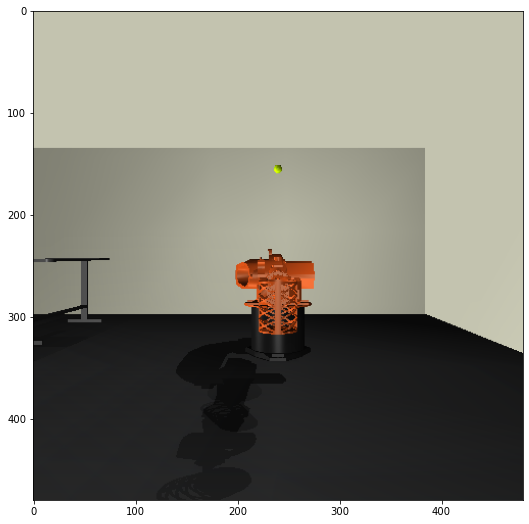

In [20]:
img,depth = viewer.read_pixels(camid=0,depth=True)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.imshow(img)
model.stat.center


In [21]:
data.qpos = 2*np.pi

In [22]:

mujoco.mj_step(model, data)

array([ 3.   , -0.9  ,  0.895])

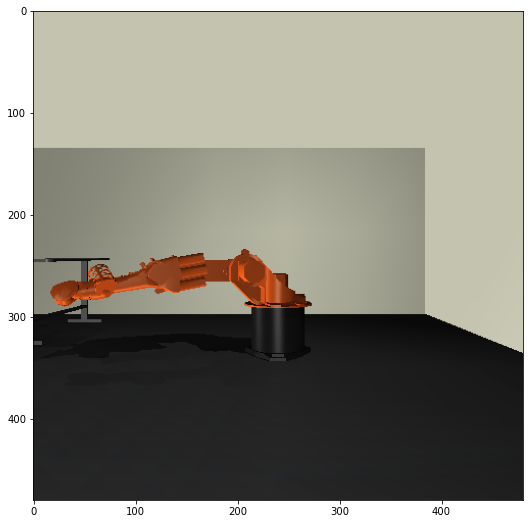

In [23]:
img,depth = viewer.read_pixels(camid=0,depth=True)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.imshow(img)
model.stat.center


In [24]:
rot_mat = data.body("target").xmat.reshape(3,3)
rot_mat

array([[-0.36418477, -0.67876798, -0.63768604],
       [ 0.82876514,  0.07617043, -0.55438832],
       [ 0.42487386, -0.73039174,  0.53479913]])

In [25]:
data.body("target")

<_MjDataBodyViews
  cacc: array([0., 0., 0., 0., 0., 0.])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([0., 0., 0., 0., 0., 0.])
  cinert: array([ 6.29177784e-09,  1.38807568e-09,  6.40244771e-09,  2.04177172e-09,
       -6.81048720e-10,  1.88542974e-09,  1.61584748e-09, -4.46375393e-09,
        1.49051091e-09,  3.53059608e-09])
  crb: array([ 6.29177784e-09,  1.38807568e-09,  6.40244771e-09,  2.04177172e-09,
       -6.81048720e-10,  1.88542974e-09,  1.61584748e-09, -4.46375393e-09,
        1.49051091e-09,  3.53059608e-09])
  cvel: array([-52722.32274666,  74481.58281927,  15705.94384676, -56874.40250068,
       -32295.17922868, -20470.76004117])
  id: 10
  name: 'target'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([ 0.41229256, -1.26113645,  0.6106986 ])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([-0.36418477, -0.67876798, -0.63768604,  0.82876514,  0.07617043,
       -0.55438832,  0.42487386, -0

In [26]:
r = Rotation.from_matrix(rot_mat)
r.as_euler('xyz')

array([-0.93877927, -0.43882254,  1.98482607])

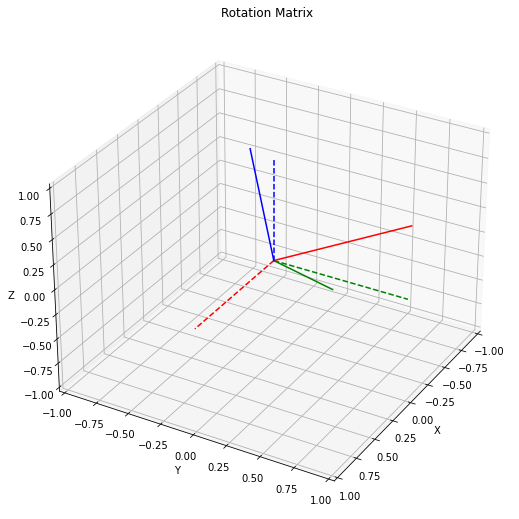

In [27]:
#plot full rotation
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot([0,1],[0,0],[0,0],"--",color='red')
ax.plot([0,0],[0,1],[0,0],"--",color='green')
ax.plot([0,0],[0,0],[0,1],"--",color='blue')
ax.plot([0,rot_mat[0,0]],[0,rot_mat[1,0]],[0,rot_mat[2,0]],color='red')
ax.plot([0,rot_mat[0,1]],[0,rot_mat[1,1]],[0,rot_mat[2,1]],color='green')
ax.plot([0,rot_mat[0,2]],[0,rot_mat[1,2]],[0,rot_mat[2,2]],color='blue')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Rotation Matrix')
ax.view_init(30, 30)
plt.show()


In [28]:
r.as_euler('xyz',degrees=True)

array([-53.78809032, -25.14267958, 113.72215689])

array([ 3.   , -0.9  ,  0.895])

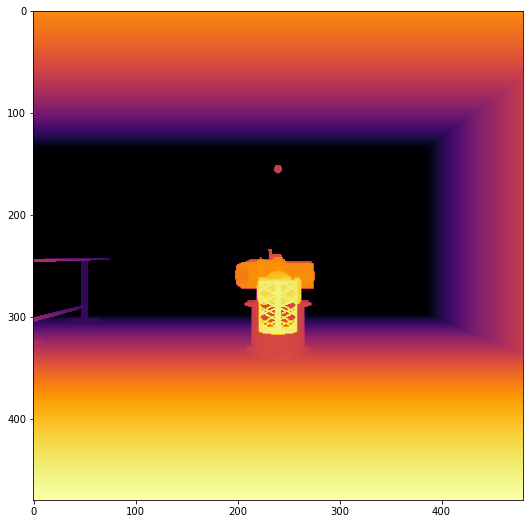

In [29]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.imshow(-depth_meters,cmap="inferno")
model.stat.center

In [30]:
def px2meters(H_inv, p, depth):
    """Converts a pixel coordinate to a 3D point in meters."""
    p = np.array([[p[0]], [p[1]], [1.0],[1.0/depth]])
    p = depth * H_inv @ p 
    return p[:3]

fy = 0.5 * height / np.tan(model.camera("depth_camera0").fovy[0] * np.pi / 360)
fx = 0.5 * width / np.tan(model.camera("depth_camera0").fovy[0] * np.pi / 360)
K = np.array(((fx, 0, width / 2), (0, fy, height / 2), (0, 0, 1)), dtype=np.float32)

import itertools


# R = np.array([[0., 0., 1.], [1., 0., 0.], [0., 1., 0.]])
R = np.array([ [0., 0., -1.], [0., 1., 0.],[-1., 0., 0.]])

    
t = np.array([[0.7],[ 0. ],[4. ]])
Rt = np.concatenate((R, t), axis=1)


K_fr = np.eye(4, dtype=np.float32)
K_fr[:3,:3] = K
Rt_fr = np.eye(4, dtype=np.float32)
Rt_fr[:3,:4] = Rt


H_inv = np.linalg.inv(K_fr @ Rt_fr)
    
real_coords = np.array([px2meters(H_inv,(i,j),depth_meters[i,j][0]) for i in range(0,depth_meters.shape[0]) for j in range(0,depth_meters.shape[1])]).reshape((width,height,3))



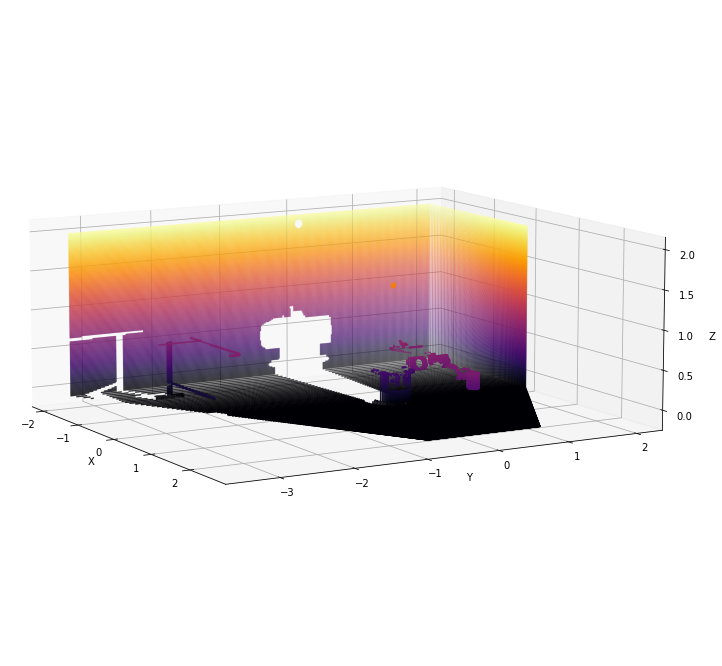

In [31]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10,-30)
real_coordsp = real_coords[real_coords[:,:,2]<2]
x,y,z = real_coordsp[:,0],real_coordsp[:,1],real_coordsp[:,2]
ax.scatter(x,y,z, c=z,s=1, cmap='inferno', linewidth=0.5)
ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xlim(-2.1,2.1)
# ax.set_ylim(-3.1,3.1)
# ax.set_zlim(0,2.1) 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title(f"R = {R}")
plt.show()


In [32]:
type(data.solver_iter)

int

In [33]:

np.deg2rad(model.camera("depth_camera0").fovy[0])


1.0122909661567112

In [34]:
# filter color 
# It converts the BGR color space of image to HSV color space
def find_circles():
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
    # Threshold of blue in HSV space
    d = 10


    lower_blue = np.array([(72-d)//2, 10*2.55//1, 10*2.55//1])
    upper_blue = np.array([(72+d)//2, 100*2.55//1, 100*2.55//1])

    # preparing the mask to overlay
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(img, img, mask = mask)

    blur = cv2.GaussianBlur(result,(5,5),0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=379, param2=11, minRadius=0, maxRadius=0)
    plt.imshow(img)
    plt.scatter(circles[0,:,0],circles[0,:,1])





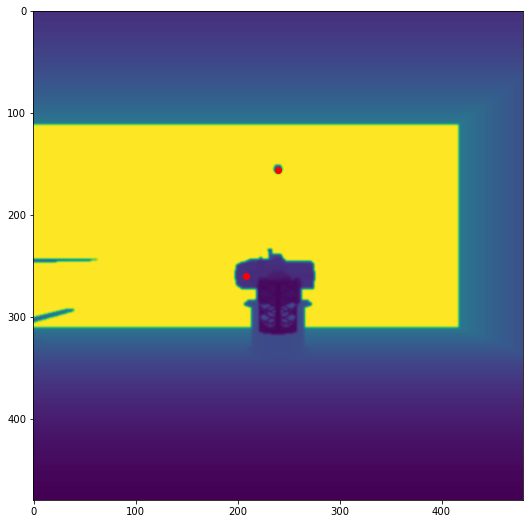

[[239.5 155.5   3.8]
 [208.5 259.5  13. ]]
[array([ 0.43344712, -0.0082373 ,  1.40017787]), array([ 1.24371672, -0.20371115,  0.57904678])]


In [35]:
depth_img = np.copy(depth_meters)
# depth_img[depth_img<1] = 10
depth_img[depth_img>=4.9] = 10
depth_img = ((depth_img/depth_img.max())*255).astype(np.uint8)
#find circles

blur = cv2.GaussianBlur(depth_img,(5,5),0)

circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 20, param1=500, param2=16, minRadius=0, maxRadius=0)
if circles is not None :
    fig=plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111)
    ax.imshow(blur)
    for circle in circles[0]:
        x,y,r = circle
        ax.scatter(x,y,c="r")
    plt.show()
    print(circles[0])
    print([real_coords[int(y),int(x)] for x,y,_ in circles[0]])


In [13]:
stripe = depth_img[:,20]
np.where(stripe == 255)

NameError: name 'depth_img' is not defined

In [ ]:
# plt.imshow(depth_img)
real_coords[302,20]
1.78551832

1.78551832

In [14]:
color = np.array((0.8, 1, 0))*255
#color hex
color = color.astype(np.uint8)
[hex(x) for x in color]

['0xcc', '0xff', '0x0']

In [3]:
def step_input():
    mujoco.mj_resetData(model, data)

    
    data.actuator("a1_intvel").ctrl = 2.722713633
    result = {"qpos":[data.joint("joint_a1").qpos[0]], "qvel":[data.joint("joint_a1").qvel[0]], "ctrlvel":[data.actuator("a1_intvel").ctrl[0]], "time":[data.time]}
    start = time.time()
    while data.time < 2:
        mujoco.mj_step(model,data)
        result["qpos"].append(data.joint("joint_a1").qpos[0])
        result["qvel"].append(data.joint("joint_a1").qvel[0])
        result["ctrlvel"].append(data.actuator("a1_intvel").ctrl[0])
        result["time"].append(data.time)
        if data.actuator("a1_intvel").ctrl[0] and data.joint("joint_a1").qpos[0] >= 2:
            data.actuator("a1_intvel").ctrl = 0.0


    end = time.time()
    # print("time: ", end-start)
    return result


In [4]:
def test_values(kp, plot=False):

    result= step_input()
    if plot:
        fig, ax = plt.subplots(3,1, figsize=(16,12),dpi=50, sharex=True)
        ax1, ax2, ax3 = ax
        
        print("last_pos", result["qpos"][-1])
        #set font size 
        


        ax1.plot(result["time"], result["ctrlvel"], label="ctrlvel", c="k")
        ax1.grid()
        ax1.set_ylabel("Velocidade alvo (rad/s)", fontsize=14)
        # ax1.set_xlabel("Tempo (s)")
        ax1.set_title("Velocidade angular de referência do eixo A1", fontsize=18)

        ax2.plot(result["time"], result["qpos"], label="qpos", c="k")
        ax2.grid()
        ax2.set_ylabel("Posição (rad)", fontsize=14)
        ax2.set_title("Posição angular do eixo A1", fontsize=18)

        ax3.plot(result["time"], result["qvel"], label="qvel", c="k")
        ax3.grid()
        ax3.set_ylabel("Esforço de controle", fontsize=14)
        ax3.set_title("Esforço de controle",  fontsize=18)
        plt.xlabel("Tempo (s)", fontsize=14)
        plt.show()
        viewer = mujoco_viewer.MujocoViewer(model, data,"offscreen")
        mujoco.mj_forward(model, data)
        img = viewer.read_pixels(camid=0)
        plt.imshow(img)
    return result


    
    

last_pos 2.166176006636796


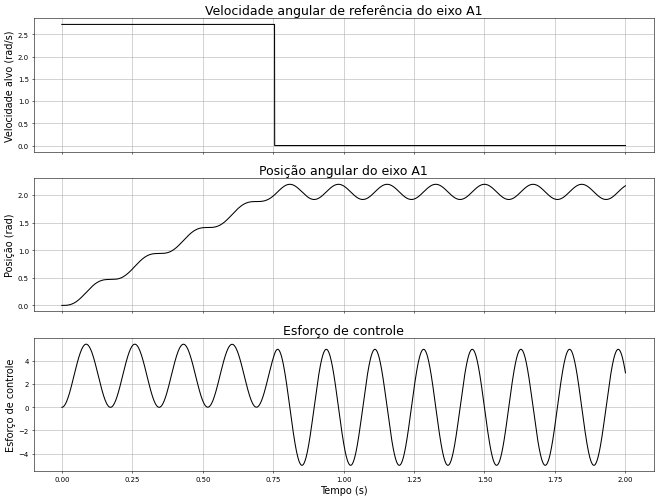

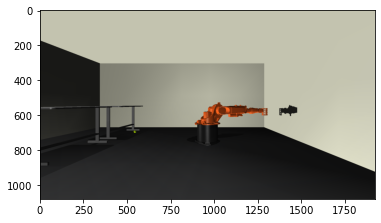

In [5]:
r=test_values(3,True)

In [74]:
ss_pos = r["qpos"][400:-1]
mujoco.

SyntaxError: invalid syntax (1845391675.py, line 2)

In [ ]:
(max(ss_pos)-min(ss_pos))/np.pi * 180

NameError: name 'ss_pos' is not defined

In [ ]:
def test_best_kp():
    kp_list = np.linspace(100000, 1000000, 200)
    result = []
    for kp in kp_list:
        r = test_values(kp)
        ss_pos = r["qpos"][len(r["qpos"])//3:-1]
        result.append((max(ss_pos)-min(ss_pos))/np.pi * 180)
        # print(kp, result[-1])
    plt.plot(kp_list, result)
    plt.grid()
    plt.show()
    return result

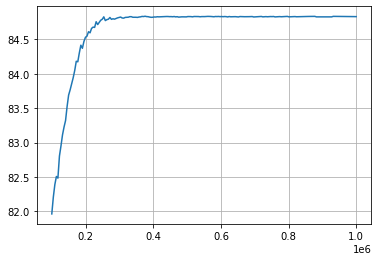

0 84.8237208113916


2512.5628140703516

In [ ]:
deviations = test_best_kp()
deviations = deviations[len(deviations)//3:-1]
print(np.argmin(deviations), np.min(deviations))
np.linspace(0, 50000, 200)[10:-1][np.argmin(deviations)]

In [ ]:
cam=model.cam("depth_camera0")

In [ ]:
mujoco.mjv_makeScene(model, data, 0)

AttributeError: module 'mujoco' has no attribute 'mjv_makeScene'

In [ ]:
ctx=mujoco.GLContext(1920, 1080)

In [ ]:
ctx.make_current()

In [ ]:
scn=mujoco.MjvScene(model,1000)

In [ ]:
mujoco.update_scene(model, data, scn, cam)

AttributeError: module 'mujoco' has no attribute 'update_scene'

In [ ]:
opt=mujoco.MjvOption()
mujoco.mjv_updateScene(model, data,opt,None,cam,1,scn)


TypeError: mjv_updateScene(): incompatible function arguments. The following argument types are supported:
    1. (m: mujoco._structs.MjModel, d: mujoco._structs.MjData, opt: mujoco._structs.MjvOption, pert: Optional[mujoco._structs.MjvPerturb], cam: mujoco._structs.MjvCamera, catmask: int, scn: mujoco._structs.MjvScene) -> None

Invoked with: <mujoco._structs.MjModel object at 0x7f49f2755770>, <mujoco._structs.MjData object at 0x7f49f256b970>, <MjvOption
  actuatorgroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  flags: array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1], dtype=uint8)
  frame: 0
  geomgroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  jointgroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  label: 0
  sitegroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  skingroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  tendongroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
>, None, <_MjModelCameraViews
  bodyid: array([0], dtype=int32)
  fovy: array([58.])
  id: 0
  ipd: array([0.05])
  mat0: array([0., 0., 1., 1., 0., 0., 0., 1., 0.])
  mode: array([0], dtype=int32)
  name: 'depth_camera0'
  pos: array([3. , 0. , 0.7])
  pos0: array([3. , 0. , 0.7])
  poscom0: array([2.69367578, 0.01172623, 0.28206348])
  quat: array([0.5, 0.5, 0.5, 0.5])
  targetbodyid: array([-1], dtype=int32)
  user: array([], dtype=float64)
>, 1, <mujoco._structs.MjvScene object at 0x7f49f23b1670>

In [ ]:
R = np.array([[  0.0000000,  1.0000000,  0.0000000],[0.0000000,  0.0000000,  1.0000000],[1.0000000,  0.0000000,  0.0000000 ]])

In [ ]:
np.linalg.inv(R)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
depth_meters[0,0][0]

2.8021276

In [ ]:
depth[20,30]

NameError: name 'depth' is not defined

In [ ]:
class person:
    def __init__(self, name, age):
        self._name = name
        self._age = age

    def __repr__(self):
        return f"Name: {self._name}, Age: {self._age}"

    @property
    def age(self):
        return self._age
    
    @age.setter
    def age(self, age):
        if age < 0:
            raise ValueError("Age must be positive")
        self._age = age
    
    

In [ ]:
a = person("luan", 20)

In [ ]:
a

Name: luan, Age: 20

In [ ]:
a.age = 30

In [ ]:
from handlers import *


In [ ]:
sim = MujocoHandler("/home/luangb/Documents/TCC/Kuka_RL_Control/environment.xml")
cam = RGBD_CamHandler(sim,size=600,windowed=False,fps=30)
cam.R = np.array([ [0., 0., -1.], [0., 1., 0.],[-1., 0., 0.]])
cam.t = np.array([[0.7],[ 0. ],[4. ]])


In [ ]:
sim.reset()
sim.set_random_state()
tracker = BallTracker(cam)

In [ ]:
tracker._Kalman.predict()

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
from filterpy.common import Q_discrete_white_noise
f = Q_discrete_white_noise(dim=3, dt=0.32, var=0.13)

In [ ]:
dt = 1/60
half_dt_squared = 0.5 * dt * dt

Tau = np.array([half_dt_squared, half_dt_squared, half_dt_squared, dt, dt, dt, 1, 1, 1], dtype=np.float32).reshape((9,1))
var = 100
Q = Tau * var* Tau.T

In [ ]:
Q.shape

(9, 9)

In [41]:
def points(P0,r,n,z=0.0):
    P = np.zeros((n,3))
    theta = np.arange(0,2*np.pi,2*np.pi/n)
    P = P0 + r*np.array([np.cos(theta),np.sin(theta),z*np.ones(n)]).T
    return P

def orientation(P0, P1):
    z = P0 - P1
    z = z/np.linalg.norm(z)
    y = np.array([0,0,-1]).round(4)
    x = np.cross(y,z).round(4)
    return f"{x[0]} {x[1]} {x[2]} {y[0]} {y[1]} {y[2]}"

def half_length(r,n):
    return r*np.sin(2*np.pi/n)

def write_xml(P0,r,n,height=1.0, z=0.0):
    P = points(P0,r,n,z).round(4)
    l = half_length(r,n).round(4)
    for point in P:
        print(f'<geom type="box" pos="{point[0]} {point[1]} {point[2]}" size="{l} {height/2} 0.001" xyaxes="{orientation(point,P0)}" rgba="0.8 0.6 0.4 1" />')
    

In [42]:
P0 = np.array([0, 0, 0])
r = 0.070
height = 0.09325*2
n = 20
write_xml(P0,r,n,height)

<geom type="box" pos="0.07 0.0 0.0" size="0.0216 0.09325 0.001" xyaxes="0.0 -1.0 0.0 0 0 -1" rgba="0.8 0.6 0.4 1" />
<geom type="box" pos="0.0666 0.0216 0.0" size="0.0216 0.09325 0.001" xyaxes="0.3085 -0.9512 0.0 0 0 -1" rgba="0.8 0.6 0.4 1" />
<geom type="box" pos="0.0566 0.0411 0.0" size="0.0216 0.09325 0.001" xyaxes="0.5876 -0.8092 0.0 0 0 -1" rgba="0.8 0.6 0.4 1" />
<geom type="box" pos="0.0411 0.0566 0.0" size="0.0216 0.09325 0.001" xyaxes="0.8092 -0.5876 0.0 0 0 -1" rgba="0.8 0.6 0.4 1" />
<geom type="box" pos="0.0216 0.0666 0.0" size="0.0216 0.09325 0.001" xyaxes="0.9512 -0.3085 0.0 0 0 -1" rgba="0.8 0.6 0.4 1" />
<geom type="box" pos="0.0 0.07 0.0" size="0.0216 0.09325 0.001" xyaxes="1.0 -0.0 0.0 0 0 -1" rgba="0.8 0.6 0.4 1" />
<geom type="box" pos="-0.0216 0.0666 0.0" size="0.0216 0.09325 0.001" xyaxes="0.9512 0.3085 0.0 0 0 -1" rgba="0.8 0.6 0.4 1" />
<geom type="box" pos="-0.0411 0.0566 0.0" size="0.0216 0.09325 0.001" xyaxes="0.8092 0.5876 0.0 0 0 -1" rgba="0.8 0.6 0.4 1" /

In [27]:
data.body("ball")

<_MjDataBodyViews
  cacc: array([0., 0., 0., 0., 0., 0.])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([0., 0., 0., 0., 0., 0.])
  cinert: array([7.95461566e-05, 7.95461566e-05, 7.95461566e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.87664100e-17, 1.69032794e-01])
  crb: array([7.95461566e-05, 7.95461566e-05, 7.95461566e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.87664100e-17, 1.69032794e-01])
  cvel: array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     , -3.44331])
  id: 1
  name: 'ball'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([0.       , 0.       , 0.8956991])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([1., 0., 0., 0., 1., 0., 0., 0., 1.])
  xipos: array([0.       , 0.       , 0.8956991])
  xmat: array([1., 0., 0., 0., 1., 0., 0., 0., 1.])
  xpos: array([0.       , 0.       , 0.

In [52]:
for i in range(5000):

    mujoco.mj_step(model, data)

In [30]:
data.contact[0]

<MjContact
  H: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])
  dim: 3
  dist: -0.0003671818424602069
  efc_address: 0
  exclude: 0
  frame: array([ 0.,  0.,  1.,  0.,  1.,  0., -1.,  0.,  0.])
  friction: array([1.e+00, 1.e+00, 5.e-03, 1.e-04, 1.e-04])
  geom1: 0
  geom2: 10
  includemargin: 0.0
  mu: 1.0
  pos: array([-2.22419829e+00,  1.22218541e-02, -1.83590921e-04])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solref: array([0.02, 1.  ])
>

In [32]:
data.geom(10)

<_MjDataGeomViews
  id: 10
  name: 'ball'
  xmat: array([ 0.70701412, -0.02303948, -0.70682403, -0.03712667,  0.99688172,
       -0.06963079,  0.70622421,  0.07547197,  0.70395408])
  xpos: array([-2.22419829,  0.01222185,  0.03393282])
>

In [33]:
data.body("target")

<_MjDataBodyViews
  cacc: array([0., 0., 0., 0., 0., 0.])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([0., 0., 0., 0., 0., 0.])
  cinert: array([ 5.87547177e-02,  1.36661531e+00,  1.30957494e+00,  2.58474253e-03,
       -2.72362242e-01,  5.38269731e-04,  6.79525239e-01, -1.34294966e-03,
        1.41510446e-01,  3.53059608e-01])
  crb: array([ 5.87547177e-02,  1.36661531e+00,  1.30957494e+00,  2.58474253e-03,
       -2.72362242e-01,  5.38269731e-04,  6.79525239e-01, -1.34294966e-03,
        1.41510446e-01,  3.53059608e-01])
  cvel: array([ 1.36168579e-04,  2.20066912e-01, -3.99119911e-06, -9.97659224e-02,
        6.29032605e-05,  3.37231791e-01])
  id: 10
  name: 'target'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([ 1.88916735e+00, -1.94858830e-08,  5.91294137e-01])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([-1.35990529e-08, -9.99998687e-01,  1.62027086e-03,  1.00000000e+00,
       -1.21255488e-

In [35]:
model.body("target")

<_MjModelBodyViews
  dofadr: array([-1], dtype=int32)
  dofnum: array([0], dtype=int32)
  geomadr: array([19], dtype=int32)
  geomnum: array([21], dtype=int32)
  id: 10
  inertia: array([0.00203056, 0.00203056, 0.00170413])
  invweight0: array([  1.96918736, 273.0104891 ])
  ipos: array([-6.14175141e-19,  3.99213842e-18, -8.13161399e-03])
  iquat: array([0.70710678, 0.        , 0.        , 0.70710678])
  jntadr: array([-1], dtype=int32)
  jntnum: array([0], dtype=int32)
  mass: array([0.35305961])
  mocapid: array([-1], dtype=int32)
  name: 'target'
  parentid: array([9], dtype=int32)
  pos: array([ 0.12425,  0.     , -0.04   ])
  quat: array([1., 0., 0., 0.])
  rootid: array([2], dtype=int32)
  sameframe: array([0], dtype=uint8)
  simple: array([0], dtype=uint8)
  subtreemass: array([0.35305961])
  user: array([], dtype=float64)
  weldid: array([8], dtype=int32)
>

In [44]:
model.body(model.geom(10).bodyid[0])

<_MjModelBodyViews
  dofadr: array([0], dtype=int32)
  dofnum: array([6], dtype=int32)
  geomadr: array([10], dtype=int32)
  geomnum: array([1], dtype=int32)
  id: 1
  inertia: array([7.95461566e-05, 7.95461566e-05, 7.95461566e-05])
  invweight0: array([5.91601179e+00, 1.25713176e+04])
  ipos: array([0., 0., 0.])
  iquat: array([1., 0., 0., 0.])
  jntadr: array([0], dtype=int32)
  jntnum: array([1], dtype=int32)
  mass: array([0.16903279])
  mocapid: array([-1], dtype=int32)
  name: 'ball'
  parentid: array([0], dtype=int32)
  pos: array([0. , 0. , 1.5])
  quat: array([1., 0., 0., 0.])
  rootid: array([1], dtype=int32)
  sameframe: array([1], dtype=uint8)
  simple: array([1], dtype=uint8)
  subtreemass: array([0.16903279])
  user: array([], dtype=float64)
  weldid: array([1], dtype=int32)
>

In [53]:
len(data.contact)

1

In [47]:
mujoco.mj_resetData(model, data)

In [54]:
data.ncon

1

In [59]:
[(model.body(model.geom(contact.geom1).bodyid[0]).name,model.body(model.geom(contact.geom2).bodyid[0]).name) for contact in data.contact]

[('world', 'ball')]

In [62]:
data.qpos

array([-1.89213219e+00,  2.12991704e-02,  3.39328182e-02,  2.33808220e-01,
       -2.48327327e-02,  9.71958432e-01, -3.72271112e-03, -1.71009980e-08,
        9.09514080e-05,  1.02432710e-04,  6.90497190e-07,  2.41778075e-03,
        2.46636864e-07])

In [63]:
data.body("ball")

<_MjDataBodyViews
  cacc: array([0., 0., 0., 0., 0., 0.])
  cfrc_ext: array([0., 0., 0., 0., 0., 0.])
  cfrc_int: array([0., 0., 0., 0., 0., 0.])
  cinert: array([ 7.95461566e-05,  7.95461566e-05,  7.95461566e-05, -7.41153829e-22,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.69032794e-01])
  crb: array([ 7.95461566e-05,  7.95461566e-05,  7.95461566e-05, -7.41153829e-22,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.69032794e-01])
  cvel: array([-1.23810575e-01,  4.52923460e+00,  1.20020869e-01,  1.54521220e-01,
        4.22397222e-03,  1.34257151e-15])
  id: 1
  name: 'ball'
  subtree_angmom: array([0., 0., 0.])
  subtree_com: array([-1.89213219,  0.02129917,  0.03393282])
  subtree_linvel: array([0., 0., 0.])
  xfrc_applied: array([0., 0., 0., 0., 0., 0.])
  ximat: array([-0.8894341 , -0.04653197,  0.45468863, -0.05001357,  0.99873895,
        0.00437555, -0.45431885, -0.01

In [74]:
np.concatenate((data.qpos[0:3],data.qvel[0:3],data.qpos[7:13]))

array([-1.89213219e+00,  2.12991704e-02,  3.39328182e-02,  1.54521220e-01,
        4.22397222e-03,  1.34256204e-15, -1.71009980e-08,  9.09514080e-05,
        1.02432710e-04,  6.90497190e-07,  2.41778075e-03,  2.46636864e-07])

In [72]:
data.qvel[0:3]

array([1.54521220e-01, 4.22397222e-03, 1.34256204e-15])

In [52]:
C = 30
zmin = 0.2
zmax = 0.8
p_max = 300

zmin = 0.2
zmax = 0.6 + (0.6 - 0.2)

def score(z):
    mid = (zmax+zmin)/2
    if zmin<z<zmax:
        return np.min([p_max,C*(np.log(0.25*(zmax-zmin)*(zmax-zmin))-np.log((z-zmin)*(zmax-z)))])
    else:
        return p_max

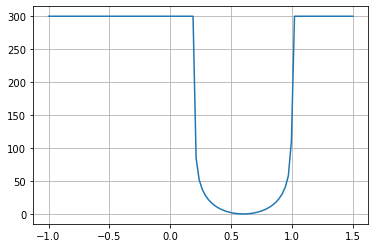

In [55]:

y = [score(z) for z in x]
plt.plot(x,y)
plt.grid()

In [64]:
def continous_barrier_penalty(x, x_min, x_max, C=1, max_penalty=1):
    if x_min < x < x_max:
        return np.min([max_penalty,C*(np.log(0.25*(x_max-x_min)*(x_max-x_min))-np.log((x-x_min)*(x_max-x)))])
    else:
        return max_penalty

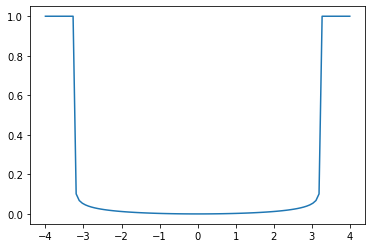

In [76]:
x = np.linspace(-4,4,100)
y=[continous_barrier_penalty(i,-3.22,3.22,C = 0.025 ,max_penalty=1) for i in x]
plt.plot(x,y)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def hyperbolic_penalty(x,xmin,xmax,lamb,tau):
    x_minus_xmin = x - xmin
    xmax_minus_x = xmax - x

    tau_squared = tau*tau
    lamb_squared = lamb*lamb

    p = -lamb*x_minus_xmin+ np.sqrt(lamb_squared*x_minus_xmin * x_minus_xmin+tau_squared)-lamb*xmax_minus_x + np.sqrt(lamb_squared*xmax_minus_x*xmax_minus_x+tau_squared)
    return p

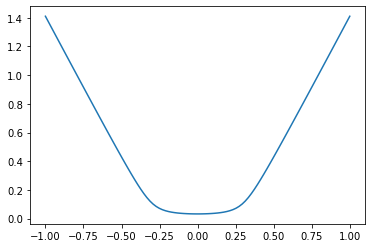

In [6]:
x = np.linspace(-1,1,100)
plt.plot(x,hyperbolic_penalty(x,-0.3,0.3,1,0.1))